In [1]:
import sys

%load_ext autoreload
%load_ext line_profiler
%autoreload 2


sys.path.append("..")

In [2]:
import csv
import os
from fractions import Fraction

import matplotlib.pyplot as plt
import numpy as np
import scienceplots  # noqa: F401
from joblib import Parallel, delayed
from matplotlib import rc
from pywt import dwt2, idwt2
from scipy.fftpack import dctn
from scipy.signal import correlate2d
from skimage.data import camera
from skimage.filters import window
from tqdm.notebook import tqdm

from zfista import minimize_proximal_gradient

In [3]:
fig_path = os.path.abspath(os.path.join("./figs"))
data_path = os.path.abspath(os.path.join("./data"))
os.makedirs(fig_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)
rc("text", usetex=True)
plt.style.use(["science", "bright"])

## Original image

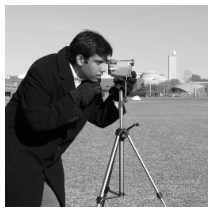

In [4]:
original = camera().astype(np.float64)[::2, ::2] / 255
plt.imshow(original, cmap="gray")
plt.axis("off")
plt.imsave(fig_path + "/cameraman_original.png", original, cmap="gray")

## Blurred and noisy image
- A Gaussian blur of size $9 \times 9$ and standard deviation $4$.
- An additive zero-mean white Gaussian noise with standard deviation $10^{-3}$.

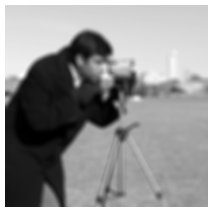

In [5]:
gaussian_kernel = window(("gaussian", 4), shape=(9, 9))
blurred = correlate2d(original, gaussian_kernel, mode="same", boundary="symm")
blurred_and_noisy = blurred + np.random.randn(256, 256) * 1e-3
plt.imshow(blurred_and_noisy, cmap="gray")
plt.axis("off")
plt.imsave(
    fig_path + "/cameraman_blurred_and_noisy.png", blurred_and_noisy, cmap="gray"
)

## Objective function
$$F(x) = f(x) + g(x),$$
where 
$$f(x) = \|Ax - b\|^2, g(x) = \lambda \|x\|_1, \lambda = 2 \times 10^{-5}, A = RW, R: \text{blur operator}, W: \text{inverse of a Haar wavelet transform.}$$
Then, we have
$$\nabla f(x) = 2 A^\top (Ax - b), \quad \mathop{\mathrm{prox}}\nolimits_{\gamma g}(x) = \mathop{\mathrm{sign}}(x) \max (|x| - \gamma \lambda, 0),$$
and $\nabla f$ is $L$-Lipschitz continuous with
$$L = 2 \lambda_\max (A^\top A).$$
Note that we can compute the eigenvalue of $A$ using the two-dimensional cosine transform (Hensen, et al., 2006).

In [6]:
l1_ratio = 2e-5


def dwt_array(image):
    coeffs = dwt2(image, "haar")
    cA, (cH, cV, cD) = coeffs
    return np.array([cA, cH, cV, cD]).flatten()


def idwt_array(array):
    cA, cH, cV, cD = array.reshape(4, 128, 128)
    return idwt2((cA, (cH, cV, cD)), "haar")


def f(x):
    return np.array(
        [
            np.linalg.norm(
                correlate2d(
                    idwt_array(x), gaussian_kernel, mode="same", boundary="symm"
                )
                - blurred_and_noisy
            )
            ** 2
        ]
    )


def jac_f(x):
    return 2 * dwt_array(
        correlate2d(
            correlate2d(idwt_array(x), gaussian_kernel, mode="same", boundary="symm")
            - blurred_and_noisy,
            gaussian_kernel,
            mode="same",
            boundary="symm",
        )
    ).reshape(1, -1)


def g(x):
    return np.array([l1_ratio * np.linalg.norm(x, ord=1)])


def prox_wsum_g(weight, x):
    return np.where(
        np.abs(x) <= l1_ratio * weight, 0, x - l1_ratio * weight * np.sign(x)
    )


unit_array = np.zeros(gaussian_kernel.shape)
unit_array[0, 0] = 1
spectrum = dctn(gaussian_kernel) / dctn(unit_array)
L = 2 * np.max(abs(spectrum)) ** 2

## FISTA
- $x^0$: Wavelet transform of the observed image.
- $(a, b) = (0, 0), (0, 1/8), (0, 1/4), (1/6, 1/144), (1/6, 37/288), (1/6, 1/4), (1/4, 1/64), (1/4, 17/128), (1/4, 1/4).$

In [7]:
x0 = dwt_array(blurred_and_noisy)
nesterov_ratios_f = [
    (0, 0),
    (0, Fraction(1, 8)),
    (0, Fraction(1, 4)),
    (Fraction(1, 6), Fraction(1, 144)),
    (Fraction(1, 6), Fraction(37, 288)),
    (Fraction(1, 6), Fraction(1, 4)),
    (Fraction(1, 4), Fraction(1, 64)),
    (Fraction(1, 4), Fraction(17, 128)),
    (Fraction(1, 4), Fraction(1, 4)),
    (Fraction(1, 2), Fraction(1, 16)),
    (Fraction(1, 2), Fraction(5, 32)),
    (Fraction(1, 2), Fraction(1, 4)),
    (Fraction(3, 4), Fraction(9, 64)),
    (Fraction(3, 4), Fraction(25, 128)),
    (Fraction(3, 4), Fraction(1, 4)),
]
nesterov_ratios = [tuple(map(float, t)) for t in nesterov_ratios_f]

In [8]:
results = Parallel(n_jobs=-1, verbose=10)(
    delayed(minimize_proximal_gradient)(
        f,
        g,
        jac_f,
        prox_wsum_g,
        x0,
        lr=1 / L,
        decay_rate=1,
        nesterov=True,
        nesterov_ratio=nesterov_ratio,
        return_all=True,
    )
    for nesterov_ratio in nesterov_ratios
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:  2.2min remaining: 14.2min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:  2.8min remaining:  7.6min
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:  3.9min remaining:  5.9min
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  4.8min remaining:  4.2min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:  5.1min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  5.3min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  5.8min finished


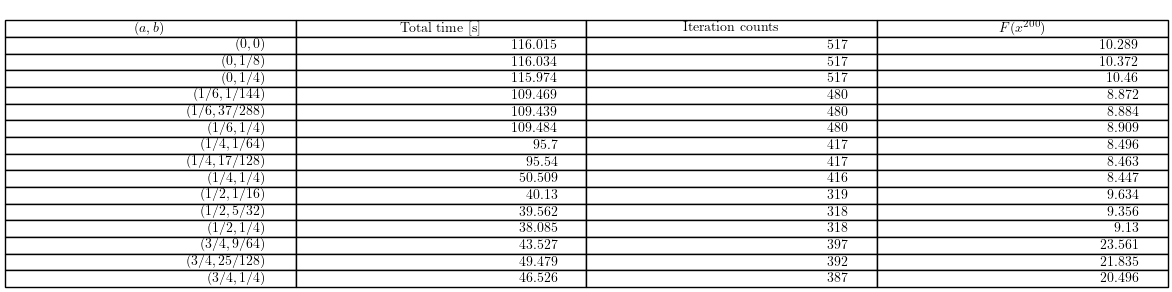

In [21]:
column_labels = ["$(a, b)$", "Total time [s]", "Iteration counts", "$F(x^{200})$"]
cell_text = []
with open(data_path + "/cameraman_ab.csv", "w") as file:
    for i, result in enumerate(results):
        cell_text.append(
            [
                "$(" + ",".join(map(str, nesterov_ratios_f[i])) + ")$",
                round(result.time, 3),
                result.nit,
                round(result.allfuns[200][0], 3),
            ]
        )
        writer = csv.writer(file, escapechar=" ", quoting=csv.QUOTE_NONE)
        writer.writerow(
            [
                ",".join(map(str, nesterov_ratios_f[i])),
                round(result.time, 3),
                result.nit,
                round(result.allfuns[200][0], 3),
            ]
        )
fig = plt.figure(figsize=(15, 0.2))
ax = fig.add_subplot(1, 1, 1)
ax.axis("tight")
ax.axis("off")
ax.table(cellText=cell_text, colLabels=column_labels)
plt.show()

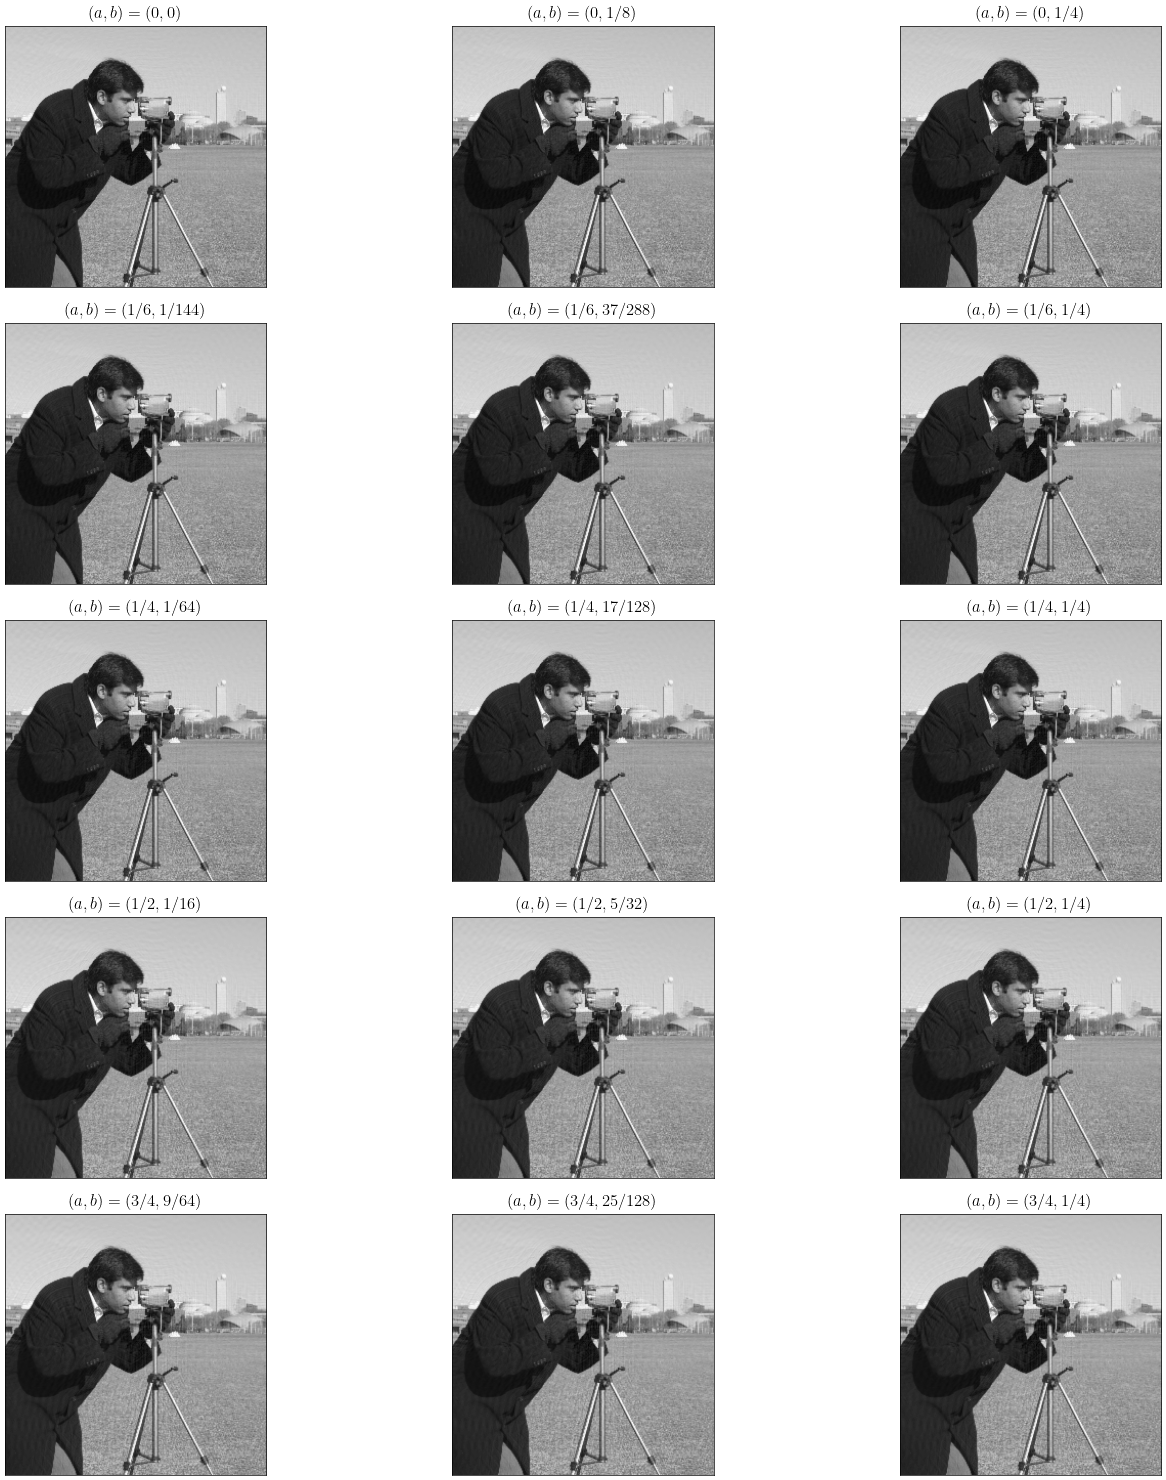

In [12]:
fig = plt.figure(figsize=(15, 15))
for i, result in enumerate(results):
    ax = fig.add_subplot(5, 3, i + 1)
    ax.imshow(idwt_array(result.x), cmap="gray")
    plt.imsave(
        fig_path + "/cameraman_deblurred_" + str(i) + ".png",
        idwt_array(result.x),
        cmap="gray",
    )
    ax.set_title("$(a, b) = (" + ",".join(map(str, nesterov_ratios_f[i])) + ")$")
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

In [13]:
x_star = dwt_array(original)
F_star = f(x_star) + g(x_star)
fvals = {}
for i, result in tqdm(enumerate(results)):
    fvals[i] = []
    for x in result.allvecs:
        fvals[i].append(f(x) + g(x) - F_star)

0it [00:00, ?it/s]

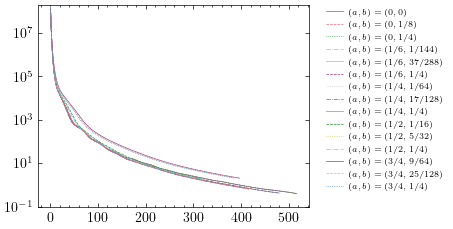

In [14]:
legends = []
line_styles = ["solid", "dashed", "dotted", "dashdot"]
for i in range(len(results)):
    plt.plot(fvals[i], linewidth=0.5, linestyle=line_styles[i % 4])
    plt.yscale("log")
    legends.append("$(a, b) = (" + ",".join(map(str, nesterov_ratios_f[i])) + ")$")
plt.legend(
    legends, bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0, fontsize=6
)
plt.ylim(1e-1, 1e8 * 2)
plt.savefig(fig_path + "/cameraman_plot.pdf", bbox_inches="tight")